# Importação de Bibliotecas e Leitura dos Dados

Iremos realizar a importação das bibliotecas que nos ajudarão na construção do modelo. Podemos destacar Optuna, para nos auxiliar na escolha dos hiper-parâmetros; Scikit, para o treinamento dos modelos; MLFlow, para que possamos ter o registro dos modelos. Além disso, também utilizar auto-sklearn como ferramenta de automação.

In [1]:
!pip install optuna
!pip install category_encoders
!pip install optuna-integration
!pip install mlflow
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from optuna.integration import SkoptSampler
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Extraindo os imports do scikit para uma outra célula por conta de problema em
# importar o autosklearn diretamente

!pip install scikit-optimize

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.9 MB/s eta 0:00:00


Para a construção do modelo, utilizaremos os dados sobre assentamentos rurais no Brasil. Esses dados foram coletados e disponibilizados pela Rede DATALUTA, uma rede de pesquisadores que realizam levantamento de dados pertinentes aos conflitos geoespaciais.

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Tabela com dados sobre assentamentos rurais no Brasil.
assent_data = pd.read_excel("/content/drive/MyDrive/data-analysis/Assentamentos.xlsx", skiprows=[0])

new_columns = assent_data.columns.str.replace(' ', '-', regex=True)
assent_data.columns = new_columns
assent_data.head()

,REGIÃO,UF,CODIGO-DO-MUNICIPIO,MUNICÍPIO,CÓDIGO-ASSENTAMENTO,TIPO-ASSENTAMENTO,NOME-ASSENTAMENTO,CONTA,ANO-CRIAÇÃO,ÁREA-(HECTARES),CAPACIDADE-(FAMILIAS),FAMÍLIAS-ASSENTADAS,FASE,TIPO-ATO-CRIAÇÃO,NUM-ATO-CR,DATA-ATO-CR,FORMA-OBT,DATA-OBT,FONTE
0,N,AC,1200138,BUJARI,AC0158000,PA,PA ABIB CURY,1,2011,117.9924,8,6,03,POR,030,2011-11-29 00:00:00,Transferência,2011-11-29 00:00:00,INCRA
1,N,AC,1200427,RODRIGUES ALVES,AC0156000,PA,PA AGRO JURUA,1,2010,2140.305,75,70,03,POR,32,2010-12-10 00:00:00,Arrecadação,2010-10-19 00:00:00,INCRA
2,N,AC,1200427,RODRIGUES ALVES,AC0121000,PA,PA ALBERTO SANTIAGO,1,2005,2160,55,55,03,POR,024,2005-08-15 00:00:00,Arrecadação,1999-03-11 00:00:00,INCRA
3,N,AC,1200179,CAPIXABA,AC0061000,PA,PA ALCOBRÁS,1,1998,7684.8457,443,430,05,POR,058,1998-11-24 00:00:00,Desapropriação,1997-10-13 00:00:00,INCRA
4,N,AC,1200302,FEIJO,AC0038000,PA,PA AMENA,1,1996,1900,19,17,04,POR,061,1996-12-26 00:00:00,Arrecadação,1980-05-23 00:00:00,INCRA


A construção do nosso modelo focará na coluna de fases. Contextualizando, assentamentos rurais possuem fases definidas pelo Programa Nacional de Reforma Agrária.

Desse modo, estamos interessados em *categorizar* a fase de um assentamento baseado em suas informações.

In [6]:
seed = 42
target = 'FASE'

# Tratamento dos Dados

Nesse momento, realizaremos o tratamento dos dados. Primeiramente, transformaremos as colunas numéricas para o tipo float. Também transfomaremos em `np.nan` os valores preenchidos com 'N.I' ou 'N.I.', que expressam dados não identificados.

In [7]:
def floatify(s):
  try:
    return float(s)
  except ValueError:
    return np.nan

In [8]:
def remove_ni(s):
  if s == 'N.I' or s == 'N.I.':
    return np.nan
  else:
    return s

In [9]:
# Colunas que observamos tipo de dado incongruente
columns = ['ÁREA-(HECTARES)', 'FAMÍLIAS-ASSENTADAS', 'FASE', 'NUM-ATO-CR']
assent_data[columns] = assent_data[columns].applymap(floatify)

# Removendo valores ni
assent_data = assent_data.applymap(remove_ni)

Removendo colunas identificadores (códigos e ids)

In [10]:
# Removendo colunas com muitos valores ou valores únicos e/ou com informação pouco relevante para análise i.e. identificadores
assent_data.drop(columns=['FONTE', 'CONTA', 'CÓDIGO-ASSENTAMENTO', 'NOME-ASSENTAMENTO', 'CODIGO-DO-MUNICIPIO'], inplace=True)

# Removendo dados faltantes com relação a datas.
assent_data.dropna(subset=['DATA-OBT'], inplace=True)
assent_data.isnull().sum()

REGIÃO                     0
UF                         0
MUNICÍPIO                  0
TIPO-ASSENTAMENTO         12
ANO-CRIAÇÃO                0
ÁREA-(HECTARES)            6
CAPACIDADE-(FAMILIAS)      0
FAMÍLIAS-ASSENTADAS      244
FASE                       0
TIPO-ATO-CRIAÇÃO          74
NUM-ATO-CR               101
DATA-ATO-CR                0
FORMA-OBT                  0
DATA-OBT                   0
dtype: int64

Conferir se os tipos estão corretos.

In [11]:
assent_data.dtypes

REGIÃO                    object
UF                        object
MUNICÍPIO                 object
TIPO-ASSENTAMENTO         object
ANO-CRIAÇÃO                int64
ÁREA-(HECTARES)          float64
CAPACIDADE-(FAMILIAS)      int64
FAMÍLIAS-ASSENTADAS      float64
FASE                     float64
TIPO-ATO-CRIAÇÃO          object
NUM-ATO-CR               float64
DATA-ATO-CR               object
FORMA-OBT                 object
DATA-OBT                  object
dtype: object

# Normalização

Função utilizada para o preenchimento de dados faltantes. Adotamos 2 diferentes abordagens:
- Categóricos: Substituir valores faltantes por um token comum, que será posteriormente tratado na encodificação
- Numéricos: Utilização uma imputação baseada no KNN

In [12]:
# Preenche dados faltantes: categóricos com o token UNK e númericos usando o KNN imputer
def fill_nan(df, type_=None):
    if type_ == 'obj':
        df.fillna('UNK', inplace=True)
    elif type_ == 'num':
        df.fillna(np.nan, inplace=True)
        imputer = KNNImputer()
        df = imputer.fit_transform(df)
    return df

Função responsável por realizar o enconding das variáveis categóricas, Para realizar o enconding optamos por algoritmo categorical boost encoder, este algoritmo faz em codificação baseado na variável alvo ('FASE').



In [13]:
# Faz o enconding das variáveis categóricas
def categorical_encoder(df, target):
    c_encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
    c_encoder.fit(df.drop(columns=[target]), df[target])
    targets = df[target]
    df = c_encoder.transform(df.drop(columns=[target]))
    return df, targets

Função que realiza a normalização dos dados numéricos, utilizamos a normalização Min-Max.

In [14]:
# Realiza a normalização
def normalize(df):
    scaler = MinMaxScaler()
    return  scaler.fit_transform(df)

Rotina de remoção de *outliers*. Utilizamos o algoritmo Isolation Forests para identificação dos dados anômalos.

In [15]:
# Remoção multivariada de outliers
def remocao_outliers(df):
    clf = IsolationForest(random_state=seed)
    outliers = clf.fit_predict(df)
    df['outlier'] = outliers
    return df[df['outlier'] == 1]

Função que realiza a divisão do dataset entre treino/teste, utilizamos uma proporção 67/33 para a divisão.

In [16]:
# Split dataset
def dataset_split(df, target, split=0.33):
    X = df.drop(columns=target).copy()
    y = df[target].copy()
    return train_test_split(X, y, test_size=split, random_state=seed, stratify=y.values)


Normalização

In [17]:
# Normalizando dados numericos
assent_data_norm = assent_data.copy()
num_cols = list(assent_data_norm._get_numeric_data().columns)
num_cols.remove('FASE')
assent_data_norm[num_cols] = normalize(assent_data[num_cols])

Imputação dos dados faltantes

In [18]:
# Imputação de dados
assent_data_imp = assent_data_norm.copy()
cat_cols = list(set(assent_data_imp.columns) - set(num_cols))
assent_data_imp[cat_cols] = fill_nan(assent_data_imp[cat_cols], type_='obj')
assent_data_imp[target] = assent_data_imp[target].astype('int64')
assent_data_imp[num_cols] = fill_nan(assent_data_imp[num_cols], type_='num')

Codificação dos dados categóricos

In [19]:
# codificando colunas categoricas
data_encoded = categorical_encoder(assent_data_imp.copy(), target)
assent_data_encoded = pd.DataFrame(data_encoded[0])
assent_data_encoded[target] = data_encoded[1]

Remoção de *outliers*

In [20]:
# Removendo outliers
assent_data_wout_out = remocao_outliers(assent_data_encoded.copy())
assent_data_wout_out.drop(columns='outlier', inplace=True)

Divisão do dataset em treino e teste

In [21]:
# Dividindo o dataset entre treino e teste (67/33)
X_train, X_test, y_train, y_test = dataset_split(assent_data_wout_out.copy(), target)
df_train = pd.DataFrame(X_train, columns=assent_data_wout_out.drop(columns=target).columns)
df_train[target] = y_train
df_test = pd.DataFrame(X_test, columns=assent_data_wout_out.drop(columns=target).columns)
df_test[target] = y_test

# Configuração MLFlow

Registraremos nossos modelos com o suporte do MLFlow. Para o dashboard, estamos utilizando ngrok.

In [26]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

In [27]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Create a new MLflow Experiment
mlflow.set_experiment("Optuna Experiment")

<Experiment: artifact_location='/content/mlruns/1', creation_time=1720723685637, experiment_id='1', last_update_time=1720723685637, lifecycle_stage='active', name='Optuna Experiment', tags={}>

É possível criar uma conta em https://dashboard.ngrok.com

Depois de criar, no lado esquerdo do dashboard vai ter um menu lateral. Clica em "Your Authtoken". Nessa página você vai ter acesso ao token para ser inserido abaixo.

O código abaixo vai gerar um log com um link após `* ngrok tunnel`. Esse link vai ter os dados dos experimentos.

In [28]:
print("Enter your authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken
··········
 * ngrok tunnel "https://1981-34-148-167-152.ngrok-free.app" -> "http://127.0.0.1:5000"


# Classificação

## Definição dos Params

Para a tarefa de classificação da **fase** dos assentamentos, treinaremos os dados nos seguintes algoritmos: Random Forest, Gradient Boosting, Decision Tree e Logistic Regression.

Para seleção dos hiper-parâmetros desses algoritmos estamos utilizando optuna. Além disso, estamos empregando cross-validation para avaliação de performance dos modelos no conjunto de teste.

Estamos salvando os parâmetros dos modelos treinados e suas métricas por meio do MLFlow.

As seguintes métricas estão sendo salva: accuracy, F1, precision e recall.

In [29]:
# Estrutura para armazenar os melhores resultados
best_results = {
    'RandomForest': {'accuracy': 0, 'params': None},
    'GradientBoosting': {'accuracy': 0, 'params': None},
    'DecisionTree': {'accuracy': 0, 'params': None},
    'LR': {'accuracy': 0, 'params': None}
}

# Definir a função de objetivo
def objective(trial):
    # Escolher o modelo
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'GradientBoosting', 'DecisionTree', 'LR'])

    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 10, 200)
        max_depth = trial.suggest_int('rf_max_depth', 2, 26)
        criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)  # Ou regressor

    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('gb_n_estimators', 10, 50)
        learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('gb_max_depth', 2, 20)

        model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth) # Ou regressor

    elif classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('dt_max_depth', 2, 26)
        criterion = trial.suggest_categorical('dt_criterion', ['gini', 'entropy'])
        splitter = trial.suggest_categorical('dt_splitter', ['best', 'random'])

        model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, splitter=splitter)


    elif classifier_name == 'LR':
        C = trial.suggest_float('C', 1e-4, 10.0)
        solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
        max_iter = trial.suggest_int('max_iter', 600, 1000)

        # Criar o modelo com os hiperparâmetros sugeridos
        model = LogisticRegression(C=C, solver=solver, max_iter=max_iter) # Escolher outro algoritmo para regressão

    # Definir validação cruzada estratificada
    kfold = StratifiedKFold(n_splits=5)

    # Avaliar o modelo usando validação cruzada
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    }
    scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()

    # Atualizar os melhores resultados se necessário
    if accuracy > best_results[classifier_name]['accuracy']:
        best_results[classifier_name]['accuracy'] = accuracy
        best_results[classifier_name]['params'] = trial.params
        best_results[classifier_name]['f1'] = f1
        best_results[classifier_name]['precision'] = precision
        best_results[classifier_name]['recall'] = recall

    # Log the model and parameters only if training was successful
    with mlflow.start_run(nested=True):
      # Logging params
      mlflow.log_param('classifier', classifier_name)
      if classifier_name == 'RandomForest':
          mlflow.log_param('rf_n_estimators', n_estimators)
          mlflow.log_param('rf_max_depth', max_depth)
          mlflow.log_param('rf_criterion', criterion)
      elif classifier_name == 'GradientBoosting':
          mlflow.log_param('gb_n_estimators', n_estimators)
          mlflow.log_param('gb_learning_rate', learning_rate)
          mlflow.log_param('gb_max_depth', max_depth)
      elif classifier_name == 'DecisionTree':
          mlflow.log_param('dt_max_depth', max_depth)
          mlflow.log_param('dt_criterion', criterion)
          mlflow.log_param('dt_splitter', splitter)
      elif classifier_name == 'LR':
          mlflow.log_param('C', C)
          mlflow.log_param('solver', solver)
          mlflow.log_param('max_iter', max_iter)

      # Logging metrics
      mlflow.log_metric('accuracy', accuracy)
      mlflow.log_metric('f1', f1)
      mlflow.log_metric('precision', precision)
      mlflow.log_metric('recall', recall)

      mlflow.sklearn.log_model(model, classifier_name)

    return accuracy

# Criar um estudo e otimizar utilizando otimização bayesiana
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-11 18:52:06,172] A new study created in memory with name: no-name-dee1c5cb-ce95-4a6b-9b20-4c801d2afe6e
[I 2024-07-11 18:52:18,330] Trial 0 finished with value: 0.6833383321929685 and parameters: {'classifier': 'LR', 'C': 2.862883433590696, 'solver': 'lbfgs', 'max_iter': 650}. Best is trial 0 with value: 0.6833383321929685.
[I 2024-07-11 18:52:29,853] Trial 1 finished with value: 0.6805124143554752 and parameters: {'classifier': 'LR', 'C': 0.9643865992989795, 'solver': 'newton-cg', 'max_iter': 628}. Best is trial 0 with value: 0.6833383321929685.
[I 2024-07-11 18:52:40,566] Trial 2 finished with value: 0.6769769708785184 and parameters: {'classifier': 'LR', 'C': 0.3238219861092937, 'solver': 'lbfgs', 'max_iter': 857}. Best is trial 0 with value: 0.6833383321929685.
[I 2024-07-11 18:52:58,687] Trial 3 finished with value: 0.7522541732667236 and parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 21, 'gb_learning_rate': 0.08151082629765873, 'gb_max_depth': 7}. Bes

## Teste dos Modelos

Para avaliação dos modelos utilizamos:
- Matriz de confusão
- Acurácia
- Área sobre a curva ROC

In [ ]:
def log_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
  with mlflow.start_run(run_name=model_name):
      model.fit(X_train, y_train)

      # Log model
      mlflow.sklearn.log_model(model, model_name)

      # Compute and log metrics
      train_score = model.score(X_train, y_train)
      test_score = model.score(X_test, y_test)

      mlflow.log_metric('train_accuracy', train_score)
      mlflow.log_metric('test_accuracy', test_score)

      # Compute additional metrics
      y_pred = model.predict(X_test)
      y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_test)

      roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
      mlflow.log_metric('roc_auc_score', roc_auc)

      # Log confusion matrix as an artifact
      cf_matrix = confusion_matrix(y_test, y_pred)
      fig, ax = plt.subplots()
      sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
      # sns.heatmap(cf_matrix, annot=True, cmap='Blues')
      ax.set_title(f'Confusion Matrix {model_name}\n')
      ax.set_xlabel('Predictions')
      ax.set_ylabel('Labels')
      plt.show()
      plt.close(fig)
      mlflow.log_figure(fig, f'confusion_matrix_{model_name}.png')

      # Log classification report as an artifact
      report_str = classification_report(y_test, y_pred)
      mlflow.log_text(report_str, f'classification_report_{model_name}.txt')

      # Print report
      print(report_str)

      print(f'{model_name} train score: {train_score}')
      print(f'{model_name} test score: {test_score}')
      print(f'{model_name} roc auc score: {roc_auc}')

### Random Forest

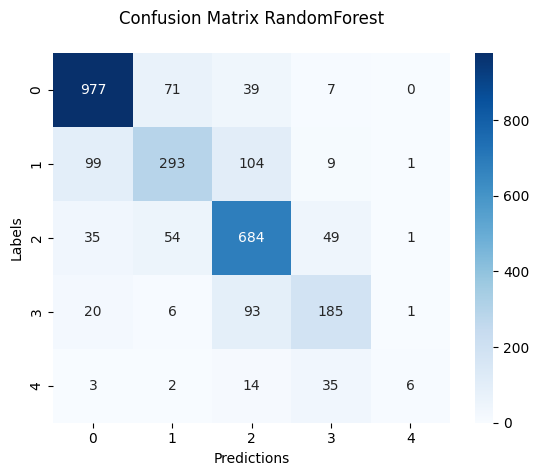

              precision    recall  f1-score   support

           3       0.86      0.89      0.88      1094
           4       0.69      0.58      0.63       506
           5       0.73      0.83      0.78       823
           6       0.65      0.61      0.63       305
           7       0.67      0.10      0.17        60

    accuracy                           0.77      2788
   macro avg       0.72      0.60      0.62      2788
weighted avg       0.76      0.77      0.76      2788

RandomForest train score: 0.9909878070330447
RandomForest test score: 0.7693687230989957
RandomForest roc auc score: 0.9347635701299613


In [ ]:
RF_test = RandomForestClassifier(n_estimators=best_results['RandomForest']['params']['rf_n_estimators'],
                                 max_depth=best_results['RandomForest']['params']['rf_max_depth'],
                                 criterion=best_results['RandomForest']['params']['rf_criterion'])

log_model_metrics('RandomForest', RF_test, X_train, y_train, X_test, y_test)

### Gradient Boosting

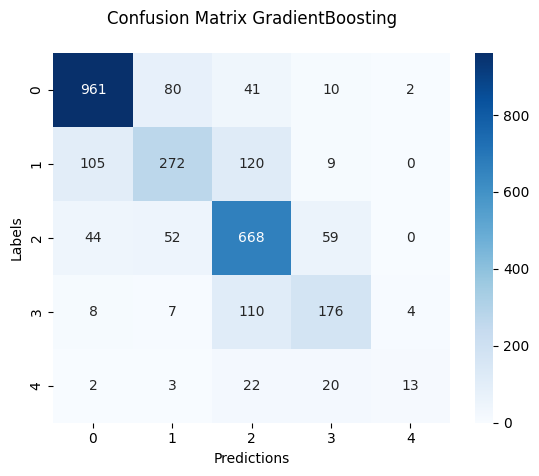

              precision    recall  f1-score   support

           3       0.86      0.88      0.87      1094
           4       0.66      0.54      0.59       506
           5       0.70      0.81      0.75       823
           6       0.64      0.58      0.61       305
           7       0.68      0.22      0.33        60

    accuracy                           0.75      2788
   macro avg       0.71      0.60      0.63      2788
weighted avg       0.75      0.75      0.74      2788

GradientBoosting train score: 0.7582611768863757
GradientBoosting test score: 0.7496413199426112
GradientBoosting roc auc score: 0.9227247898109205


In [ ]:
GBC_test = GradientBoostingClassifier(n_estimators=best_results['GradientBoosting']['params']['gb_n_estimators'],
                                      learning_rate=best_results['GradientBoosting']['params']['gb_learning_rate'],
                                      max_depth=best_results['GradientBoosting']['params']['gb_max_depth'])

log_model_metrics('GradientBoosting', GBC_test, X_train, y_train, X_test, y_test)

### Decision Tree

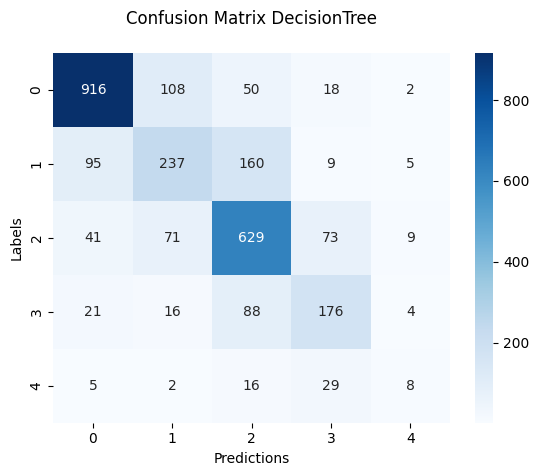

              precision    recall  f1-score   support

           3       0.85      0.84      0.84      1094
           4       0.55      0.47      0.50       506
           5       0.67      0.76      0.71       823
           6       0.58      0.58      0.58       305
           7       0.29      0.13      0.18        60

    accuracy                           0.71      2788
   macro avg       0.59      0.56      0.56      2788
weighted avg       0.70      0.71      0.70      2788

DecisionTree train score: 0.7709842728397244
DecisionTree test score: 0.7051649928263989
DecisionTree roc auc score: 0.8473266647403609


In [ ]:
DT_test = DecisionTreeClassifier(max_depth=best_results['DecisionTree']['params']['dt_max_depth'],
                                criterion=best_results['DecisionTree']['params']['dt_criterion'],
                                splitter=best_results['DecisionTree']['params']['dt_splitter'])

log_model_metrics('DecisionTree', DT_test, X_train, y_train, X_test, y_test)

### Logistic Regression

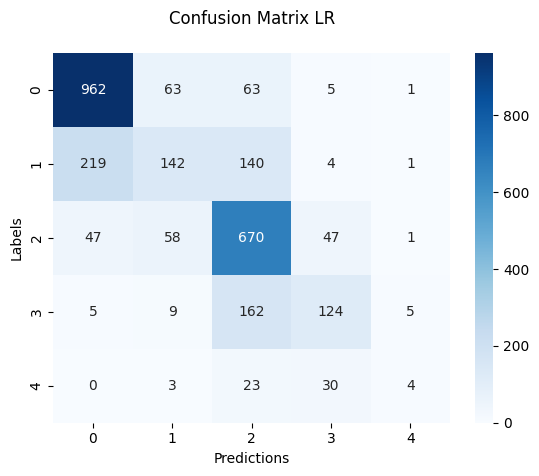

              precision    recall  f1-score   support

           3       0.78      0.88      0.83      1094
           4       0.52      0.28      0.36       506
           5       0.63      0.81      0.71       823
           6       0.59      0.41      0.48       305
           7       0.33      0.07      0.11        60

    accuracy                           0.68      2788
   macro avg       0.57      0.49      0.50      2788
weighted avg       0.66      0.68      0.66      2788

LR train score: 0.6909347941332391
LR test score: 0.6822094691535151
LR roc auc score: 0.8973224392123557


In [ ]:
LR_test = LogisticRegression(C=best_results['LR']['params']['C'],
                             solver=best_results['LR']['params']['solver'],
                             max_iter=best_results['LR']['params']['max_iter'])

log_model_metrics('LR', LR_test, X_train, y_train, X_test, y_test)

## Otimizando o melhor modelo

No passo anterior identificamos que o melhor modelo foi o Random Forest. Nessa etapa realizamos uma novas rodadas de treinamentos utilizando o Random Forest e variando mais hiperparâmetros no intuito de encontrar uma configuração ótima de algoritmo.

In [ ]:
best_results_opt = {}

def objective_opt(trial, classifier_name='RandomForest'):

    n_estimators = trial.suggest_int('rf_n_estimators', 100, 400)
    max_depth = trial.suggest_int('rf_max_depth', 5, 50)
    criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 200)
    min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 2, 200)
    bootstrap = trial.suggest_categorical('rf_bootstrap', [True, False])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)

    # Definir validação cruzada estratificada
    kfold = StratifiedKFold(n_splits=5)

    # Avaliar o modelo usando validação cruzada
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    }

    scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()

    # Atualizar os melhores resultados se necessário
    if accuracy > best_results_opt['accuracy']:
        best_results_opt['accuracy'] = accuracy
        best_results_opt['params'] = trial.params
        best_results_opt['f1'] = f1
        best_results_opt['precision'] = precision
        best_results_opt['recall'] = recall

    # Log the model and parameters only if training was successful
    with mlflow.start_run(nested=True):
      # Logging params
      mlflow.log_param('classifier', classifier_name)
      if classifier_name == 'RandomForest':
          mlflow.log_param('rf_n_estimators', n_estimators)
          mlflow.log_param('rf_max_depth', max_depth)
          mlflow.log_param('rf_criterion', criterion)
          mlflow.log_param('rf_max_features', max_features)
          mlflow.log_param('rf_min_samples_split', min_samples_split)
          mlflow.log_param('rf_min_samples_leaf', min_samples_leaf)
          mlflow.log_param('rf_bootstrap', bootstrap)

    # Logging metrics
      mlflow.log_metric('accuracy', accuracy)
      mlflow.log_metric('f1', f1)
      mlflow.log_metric('precision', precision)
      mlflow.log_metric('recall', recall)

      mlflow.sklearn.log_model(model, classifier_name)

    return accuracy

best_results_opt['accuracy'] = 0.0
study = optuna.create_study(direction='maximize')
study.optimize(objective_opt, n_trials=250)

[I 2024-07-10 18:51:51,024] A new study created in memory with name: no-name-192740ab-b74f-4c31-b06f-b59d4fa62b97
[I 2024-07-10 18:52:04,400] Trial 0 finished with value: 0.7211540804753915 and parameters: {'rf_n_estimators': 171, 'rf_max_depth': 27, 'rf_criterion': 'gini', 'rf_max_features': 'sqrt', 'rf_min_samples_split': 100, 'rf_min_samples_leaf': 112, 'rf_bootstrap': False}. Best is trial 0 with value: 0.7211540804753915.
[I 2024-07-10 18:52:19,675] Trial 1 finished with value: 0.7024231972081368 and parameters: {'rf_n_estimators': 303, 'rf_max_depth': 30, 'rf_criterion': 'entropy', 'rf_max_features': 'log2', 'rf_min_samples_split': 62, 'rf_min_samples_leaf': 138, 'rf_bootstrap': True}. Best is trial 0 with value: 0.7211540804753915.
[I 2024-07-10 18:52:32,937] Trial 2 finished with value: 0.7384707551089906 and parameters: {'rf_n_estimators': 290, 'rf_max_depth': 26, 'rf_criterion': 'gini', 'rf_max_features': 'log2', 'rf_min_samples_split': 165, 'rf_min_samples_leaf': 38, 'rf_boo

### Resultado da otimização

Como resultado dessa nova rodada de otimização conseguimos melhorar o desempenho do modelo na base de teste. Alcançamos um ganho de acurácia e Roc Score, mas também, no F1-Score das classes 4, 6 e 7, sendo a classe 7 a que mais melhorou (29%).

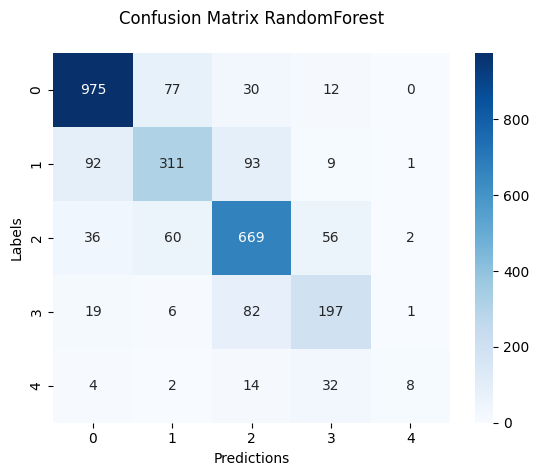

              precision    recall  f1-score   support

           3       0.87      0.89      0.88      1094
           4       0.68      0.61      0.65       506
           5       0.75      0.81      0.78       823
           6       0.64      0.65      0.64       305
           7       0.67      0.13      0.22        60

    accuracy                           0.77      2788
   macro avg       0.72      0.62      0.63      2788
weighted avg       0.77      0.77      0.77      2788

RandomForest train score: 0.98745361371267
RandomForest test score: 0.7747489239598279
RandomForest roc auc score: 0.9370444073041435


In [ ]:
RF_test = RandomForestClassifier(n_estimators=best_results_opt['params']['rf_n_estimators'],
                                 max_depth=best_results_opt['params']['rf_max_depth'],
                                 criterion=best_results_opt['params']['rf_criterion'],
                                 max_features=best_results_opt['params']['rf_max_features'],
                                 min_samples_split=best_results_opt['params']['rf_min_samples_split'],
                                 min_samples_leaf=best_results_opt['params']['rf_min_samples_leaf'],
                                 bootstrap=best_results_opt['params']['rf_bootstrap']
                                 )

log_model_metrics('RandomForest', RF_test, X_train, y_train, X_test, y_test)

# Auto Sklearn

## Instalação de dependências

Importar o Auto Sklearn por meio dos comandos padrões estava dando erro:
```
!pip install auto-sklearn
import autosklearn.classification
```

Por isso, estamos realizando a instalação através da discussão presente em https://github.com/automl/auto-sklearn/issues/1684.

In [ ]:
# 1. uninstall all affected packages
!pip uninstall -y Cython scipy pyparsing scikit_learn imbalanced-learn mlxtend yellowbrick

Found existing installation: Cython 3.0.10
Uninstalling Cython-3.0.10:
  Successfully uninstalled Cython-3.0.10
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: pyparsing 3.1.2
Uninstalling pyparsing-3.1.2:
  Successfully uninstalled pyparsing-3.1.2
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
Found existing installation: mlxtend 0.22.0
Uninstalling mlxtend-0.22.0:
  Successfully uninstalled mlxtend-0.22.0
Found existing installation: yellowbrick 1.5
Uninstalling yellowbrick-1.5:
  Successfully uninstalled yellowbrick-1.5


In [ ]:
# 2. install packages to be downgraded
!pip install Cython==0.29.36 scipy==1.9 pyparsing==2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.15 requires scikit-learn, which is not installed.
librosa 0.10.2.post1 requires scikit-learn>=0.20.0, which is not installed.
qudida 0.0.4 requires scikit-learn>=0.19.1, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
httplib2 0.22.0 requires pyparsing!=3.0.0,!=3.0.1,!=3.0.2,!=3.0.3,<4,>=2.

In [ ]:
# 3. install older scikit-learn disregarding its dependencies
!pip install scikit-learn==0.24.2 --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.24.2-cp310-cp310-linux_x86_64.whl size=22238026 sha256=6f3c4e9d6368a90c536173e7f23c5aa4cbcc25aaee410991549e11e6deb42a16
  Stored in directory: /root/.cache/pip/wheels/13/a4/68/4e78865652fa14db4a162b491e5138565f97646f9e1f2ab8cc
Successfully built scikit-learn
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.11.0 requires scikit-learn>=1.2.2, but you have scikit-learn 0.24.2 which is incompatible.


In [ ]:
# 4. finally install auto-sklearn
!pip install auto-sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 75.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641936 sha256=46e61534ba4842c6b76987c1ce53f96071ab1eb95d020778bece844b3c6a772a
  Stored in directory: /root/.cache/pip/wheels/4d/0a/f9/8c1a06bcc36bc16b467b044b5bb03a90f92a5c5e6cd443414b
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl

In [ ]:
# 5. then, try loading the package repeatedly until trash in its dependencies are clean
import autosklearn
import autosklearn.classification
import sklearn.model_selection
import sklearn.metrics

## Treinamento

Com o autosklearn instalado corretamente no Colab, podemos treinar o modelo utilizando essa biblioteca.

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=360)

In [ ]:
best_pipeline = automl.get_models_with_weights()[0][1]

print(best_pipeline)

SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'adaboost', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:adaboost:algorithm': 'SAMME', 'classifier:adaboost:learning_rate': 0.2487958078311133, 'classifier:adaboost:max_depth': 5, 'classifier:adaboost:n_estimators': 219, 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'none'},
dataset_properties={
  'task': 2,
  'sparse': False,
  'multilabel': False,
  'multiclass': True,
  'target_type': 'classification',
  'signed': False})


Observamos que o classificador encontrado pelo auto-sklearn foi o AdaBoost com os seguintes hiperparâmetros:
* classifier:adaboost
  : 'SAMME' (o algoritmo escolhido para o AdaBoost é SAMME).
* classifier:adaboost
  : 0.2487958078311133 (a taxa de aprendizado do AdaBoost).
* classifier:adaboost
  : 5 (a profundidade máxima das árvores de decisão no AdaBoost).
* classifier:adaboost
  : 219 (o número de estimadores ou árvores no AdaBoost).

## Avaliação

In [ ]:
train_score = automl.score(X_train, y_train)
test_score = automl.score(X_test, y_test)

In [ ]:
y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1] if hasattr(automl, "predict_proba") else np.zeros_like(y_test)
roc_auc = roc_auc_score(y_test, automl.predict_proba(X_test), multi_class='ovr')

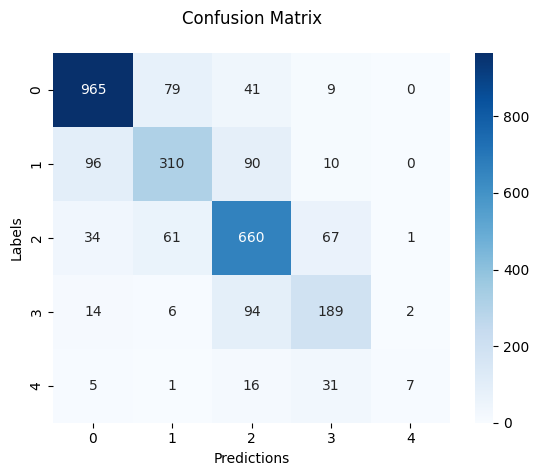

              precision    recall  f1-score   support

           3       0.87      0.88      0.87      1094
           4       0.68      0.61      0.64       506
           5       0.73      0.80      0.77       823
           6       0.62      0.62      0.62       305
           7       0.70      0.12      0.20        60

    accuracy                           0.76      2788
   macro avg       0.72      0.61      0.62      2788
weighted avg       0.76      0.76      0.76      2788

Auto-sklearn train score: 0.9153560699770278
Auto-sklearn test score: 0.7643472022955524
Auto-sklearn roc auc score: 0.9354994461640906


In [ ]:
 # Log confusion matrix as an artifact
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
# sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title(f'Confusion Matrix\n')
ax.set_xlabel('Predictions')
ax.set_ylabel('Labels')
plt.show()

report_str = classification_report(y_test, y_pred)
print(report_str)
print(f'Auto-sklearn train score: {train_score}')
print(f'Auto-sklearn test score: {test_score}')
print(f'Auto-sklearn roc auc score: {roc_auc}')

O modelo gerado pela biblioteca teve um desempenho muito próximo ao que obtivemos com o Random Forest, mas com uma taxa um pouco mais baixa de overfitting no conjunto de treinamento. Ambos tiveram uma alta pontuação no ROC AUC, mesmo com a fase "7" possuindo um baixo recall. Isso indica que possíveis problemas de desbalanceamento ou variabilidade nos dados.

Percebemos, no entanto, que ao considerar a distribuição e quantidade dos dados, o modelo se saiu razoavelmente bem.